# Prelim

CD34 Multiome RNA analysis notebooks. 

Data available at `/fh/fast/setty_m/grp/lab-datasets/cd34-multiome`

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
import pyranges as pr
import warnings

In [3]:
import palantir 
import phenograph
import harmony

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [6]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [7]:
from joblib import Parallel, delayed
from scipy.sparse import hstack, csr_matrix, issparse
import gc


def _dot_func(x, y):
    return x.dot(y)


def impute_data(dm_res, ad, n_steps=3):
    T_steps = dm_res['T'] ** n_steps
    T_steps = T_steps.astype(np.float32)

    # RUn in parallel
    seq = np.append(np.arange(0, ad.X.shape[1], 100), [ad.X.shape[1]])
    res = Parallel(n_jobs=-1)(delayed(_dot_func)(T_steps, ad.X[:, seq[i - 1]:seq[i]]) for i in range(1, len(seq)))
    imputed_data = hstack(res)
    imputed_data = imputed_data.todense()
    imputed_data[imputed_data < 1e-2] = 0
    gc.collect()

    return imputed_data

# Load data

In [8]:
data_dir = '/fh/fast/setty_m/grp/lab-datasets/cd34-multiome/'

In [9]:
# RNA and ATAC data
samples = ['rep1', 'rep2']

rna_ad_dict, atac_ad_dict = dict(), dict()
for r in samples:
    comb_ad = sc.read_10x_h5(data_dir + r + '/filtered_feature_bc_matrix.h5', gex_only=False)
    comb_ad.obs_names = 'cd34_multiome_' + r + '#'+ comb_ad.obs_names
    
    # RNA
    rna_ad_dict[r] = comb_ad[:, comb_ad.var['feature_types'] == 'Gene Expression']
    rna_ad_dict[r].var_names_make_unique()
    rna_ad_dict[r].obs['sample'] = r
    
    # ATAC
    atac_ad_dict[r] = comb_ad[:, comb_ad.var['feature_types'] == 'Peaks']
    atac_ad_dict[r].var_names_make_unique()


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [10]:
# Cells from each sample 
sample_cells = dict()
for sample in samples:
    sample_cells[sample] = rna_ad_dict[sample].obs_names

In [11]:
# Per barcode metrics 
bc_metrics_dict = dict()
for sample in samples:
    bc_metrics_dict[sample] = pd.read_csv(data_dir + r + '/per_barcode_metrics.csv', 
                index_col=0)
    bc_metrics_dict[sample].index = 'cd34_multiome_' + sample + '#' +bc_metrics_dict[sample].index 
    bc_metrics_dict[sample] = bc_metrics_dict[sample].loc[rna_ad_dict[sample].obs_names]
    # FRIP
    bc_metrics_dict[sample]['FRIP'] = bc_metrics_dict[sample]['atac_peak_region_fragments']/bc_metrics_dict[sample]['atac_fragments']

# Preprocess

## QC

In [12]:
# QC metrics include mitochondrial fractions from scanpy 
for r in samples:
    rna_ad = rna_ad_dict[r]
    rna_ad.var['mt'] = rna_ad.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(rna_ad, qc_vars=['mt'], inplace=True, percent_top=None, log1p=False, )

In [13]:
# QC metrics include mitochondrial fractions from scanpy 
for r in samples:
    atac_ad = atac_ad_dict[r]
    sc.pp.calculate_qc_metrics(atac_ad, inplace=True, percent_top=None, log1p=False, )

### Filtering cells based on RNA

Text(0.5, 0.98, 'log10 molecule counts')

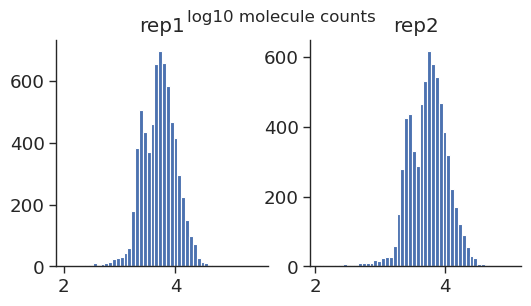

In [14]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip (samples, fig):
    rna_ad = rna_ad_dict[sample]
    ax.hist(np.log10(rna_ad.obs['total_counts'][sample_cells[sample]]), 50)
    ax.set_title(sample)
sns.despine()
plt.suptitle('log10 molecule counts')

Text(0.5, 0.98, 'log10 molecule counts')

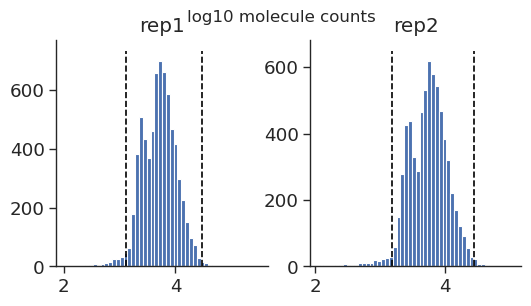

In [15]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip (samples, fig):
    rna_ad = rna_ad_dict[sample]
    THRESHOLDS = np.log10(np.percentile((rna_ad.obs['total_counts']), [2.5, 99.5]))
    ax.hist(np.log10(rna_ad.obs['total_counts'][sample_cells[sample]]), 50)
    ax.vlines(THRESHOLDS, ax.get_ylim()[0], ax.get_ylim()[1], color='black', linestyle='--')
    ax.set_title(sample)
sns.despine()
plt.suptitle('log10 molecule counts')

In [16]:
for sample, ax in zip (samples, fig):
    rna_ad = rna_ad_dict[sample]
    cells = rna_ad.obs_names
    
    # Filter
    THRESHOLDS = np.percentile((rna_ad.obs['total_counts']), [2.5, 99.5])
    sample_cells[sample] = cells[(rna_ad.obs['total_counts'][cells] > THRESHOLDS[0]) & \
        (rna_ad.obs['total_counts'][cells] < THRESHOLDS[1])]

Text(0.5, 0.98, 'log10 molecule counts')

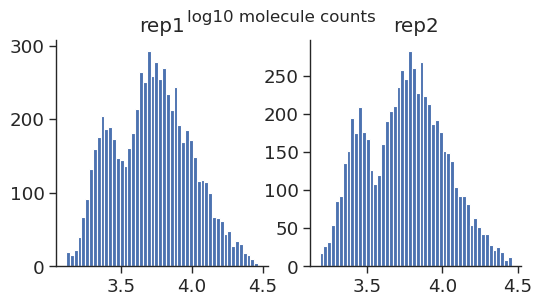

In [17]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip (samples, fig):
    rna_ad = rna_ad_dict[sample]
    ax.hist(np.log10(rna_ad.obs['total_counts'][sample_cells[sample]]), 50)
    ax.set_title(sample)
sns.despine()
plt.suptitle('log10 molecule counts')

### Filtering based on ATAC

/app/software/SciPy-bundle/2020.03-foss-2020a-Python-3.8.2/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/app/software/SciPy-bundle/2020.03-foss-2020a-Python-3.8.2/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0.98, 'Fraction of reads in peaks')

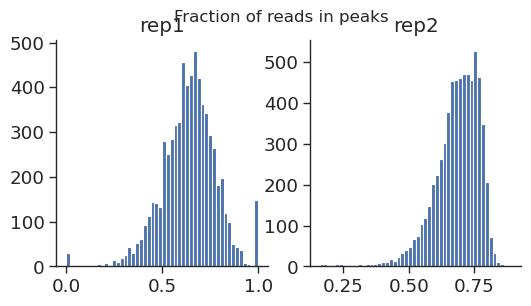

In [18]:
## CAUTION: CellRanger peak calling is unreliable and we only use it here to filter cells with low 
##          fraction of reads in peaks. This is ok since CellRanger peak caller dramatically over estimates 
##          the peak widths. We might incur some false negatives, but thats an acceptable error for filtering   
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip (samples, fig):
    ax.hist(bc_metrics_dict[sample]['FRIP'][sample_cells[sample]], 50)
    ax.set_title(sample)
sns.despine()
plt.suptitle('Fraction of reads in peaks')

In [19]:
THRESHOLD = 0.4
for sample in samples:
    sample_cells[sample] = sample_cells[sample][bc_metrics_dict[sample]['FRIP'][sample_cells[sample]] > THRESHOLD]

Text(0.5, 0.98, 'log10 molecule counts')

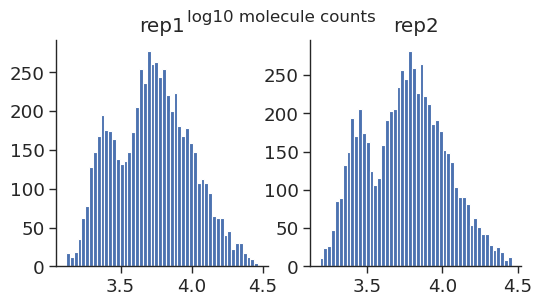

In [20]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip (samples, fig):
    rna_ad = rna_ad_dict[sample]
    ax.hist(np.log10(rna_ad.obs['total_counts'][sample_cells[sample]]), 50)
    ax.set_title(sample)
sns.despine()
plt.suptitle('log10 molecule counts')

### Filter based on mitochondria

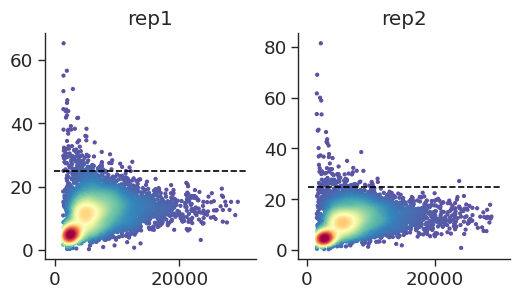

In [21]:
# Mitochondrial fractions compared to total molecules (colored by density)
MITO_THRESHOLD = 25
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip(samples, fig):
    rna_ad = rna_ad_dict[sample]
    
    # Density 
    x,y,dens = palantir.plot.density_2d(rna_ad.obs['total_counts'][sample_cells[sample]], 
               rna_ad.obs['pct_counts_mt'][sample_cells[sample]])
    
    ax.scatter(x, y, c=dens, s=5)
    ax.hlines(MITO_THRESHOLD, ax.get_xlim()[0], ax.get_xlim()[1], color='black', linestyle='--')
    ax.set_title(sample)
sns.despine()



In [22]:
for sample in samples:
    cells = sample_cells[sample]
    sample_cells[sample] = cells[rna_ad_dict[sample].obs['pct_counts_mt'][cells] < MITO_THRESHOLD]

## Combine samples 

In [38]:
sample = samples[0]
ad = rna_ad_dict[sample][sample_cells[sample]]
for sample in samples[1:]:
    ad = ad.concatenate(rna_ad_dict[sample][sample_cells[sample]], 
                            index_unique=None, batch_key='batch')
ad

AnnData object with n_obs × n_vars = 12669 × 36601
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1'

In [39]:
# Clean up var object
ad.var = pd.DataFrame(index=ad.var_names)

In [40]:
# Filter cells
sc.pp.filter_genes(ad, min_cells=50)

In [41]:
ad

AnnData object with n_obs × n_vars = 12669 × 17677
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'n_cells'

In [42]:
raw_ad = ad.copy()

### Doublet scores  (post filtering)

In [43]:
# Install scrublet using `pip install scrublet`
import scrublet as scr

In [45]:
doublet_scores = pd.Series(0.0, index=ad.obs_names)

for sample in samples:
    cells = ad.obs_names[ad.obs['sample'] == sample]
    scrub = scr.Scrublet(raw_ad[cells, :].X)
    scores, predicted_doublets = scrub.scrub_doublets()
    doublet_scores[cells] = scores

ad.obs['DoubletScores'] = doublet_scores.values

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.27
Detected doublet rate = 5.6%
Estimated detectable doublet fraction = 52.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.7%
Elapsed time: 12.9 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 3.8%
Estimated detectable doublet fraction = 48.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.9%
Elapsed time: 9.2 seconds


## Analysis

In [46]:
# Normalize and log transform
sc.pp.normalize_per_cell(ad)
log_transform(ad)

In [47]:
# Highly variable genes [Num. of genes is a paramter, typically 1.5-2.5k genes work well]
sc.pp.highly_variable_genes(ad, flavor='cell_ranger', n_top_genes=2500)
ad

AnnData object with n_obs × n_vars = 12669 × 17677
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

In [48]:
# PCA
# 50 comps is an approxmiation here - choose number of components by knee point or fraction of explained variance
n_comps = 50
sc.pp.pca(ad, use_highly_variable=True, n_comps=n_comps)

In [49]:
# UMAP and Leiden - requires the computation of nearest neighbors
# Ignore numba warnings in neighborhood computation
warnings.filterwarnings('ignore')
sc.pp.neighbors(ad, use_rep='X_pca')
warnings.filterwarnings('default')
sc.tl.umap(ad)
sc.tl.leiden(ad)
ad

AnnData object with n_obs × n_vars = 12669 × 17677
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [50]:
# Diffusion maps 
warnings.filterwarnings('ignore')
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(ad.obsm['X_pca'], index=ad.obs_names))
warnings.filterwarnings('default')
ad.obsp['DM_Kernel'] = dm_res['kernel']
ad.obsm['DM_EigenVectors'] = dm_res['EigenVectors'].values
ad.uns['DMEigenValues'] = dm_res['EigenValues'].values
ad

Determing nearest neighbor graph...


AnnData object with n_obs × n_vars = 12669 × 17677
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'DMEigenValues'
    obsm: 'X_pca', 'X_umap', 'DM_EigenVectors'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'DM_Kernel'

In [51]:
# Force directed layout
ad.obsm['X_FDL'] = harmony.plot.force_directed_layout(dm_res['kernel']).values

100%|██████████| 500/500 [02:27<00:00,  3.40it/s]

BarnesHut Approximation  took  74.68  seconds
Repulsion forces  took  65.20  seconds
Gravitational forces  took  0.46  seconds
Attraction forces  took  3.25  seconds
AdjustSpeedAndApplyForces step  took  1.48  seconds


In [52]:
# Phenograph 
ad.obs['phenograph'], _, _ = phenograph.cluster(ad.obsm['X_pca'])
ad.obs['phenograph'] = ad.obs['phenograph'].astype(str)
ad

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 3.022372245788574 seconds
Jaccard graph constructed in 3.5870234966278076 seconds
Wrote graph to binary file in 2.45219087600708 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.846574
After 2 runs, maximum modularity is Q = 0.847863
After 3 runs, maximum modularity is Q = 0.848987
Louvain completed 23 runs in 8.50242304801941 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 19.375495433807373 seconds


AnnData object with n_obs × n_vars = 12669 × 17677
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'DMEigenValues'
    obsm: 'X_pca', 'X_umap', 'DM_EigenVectors', 'X_FDL'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'DM_Kernel'

In [53]:
# Imputation
ad.obsm['MAGIC_imputed_data'] = impute_data(dm_res, ad)

# Visualize results

In [54]:
ad.obs['log_n_counts'] = np.log10(ad.obs['total_counts'])

Note that in the sample the two samples coincide very clearly indicating that there is no batch effect. This is completely expected since the two replicates were generated using cells from the same individual. Separation of cells based on sample here is a good diagnostic for batch effects

... storing 'sample' as categorical
... storing 'phenograph' as categorical


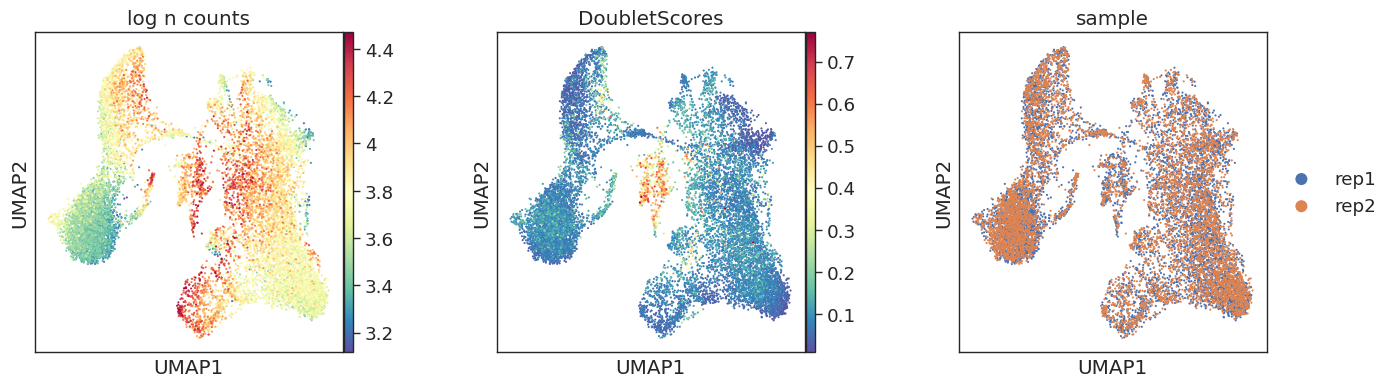

In [55]:
sc.pl.scatter(ad, basis='umap', color=['log_n_counts', 'DoubletScores', 'sample'])

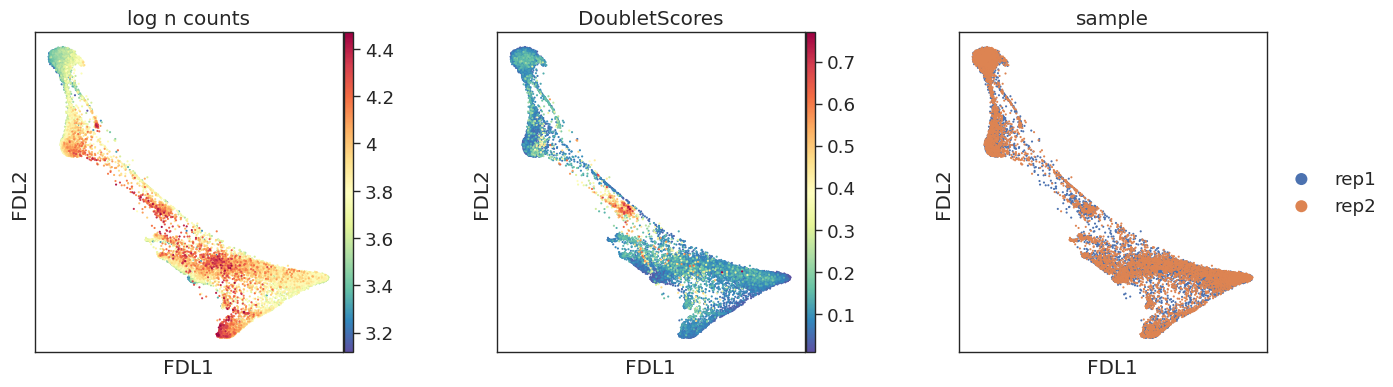

In [56]:
sc.pl.scatter(ad, basis='FDL', color=['log_n_counts', 'DoubletScores', 'sample'])

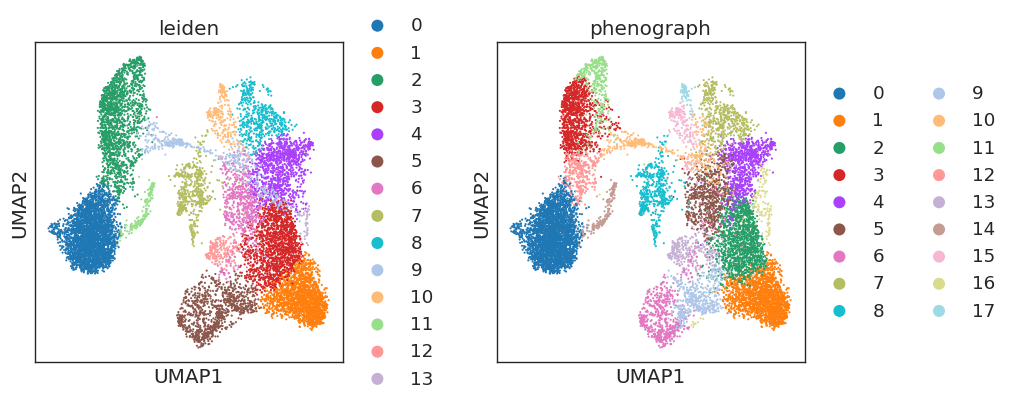

In [57]:
sc.pl.scatter(ad, basis='umap', color=['leiden', 'phenograph'])

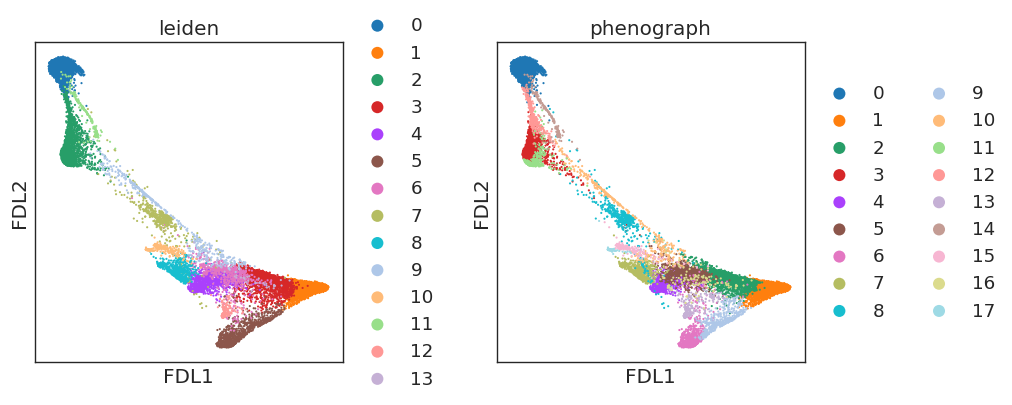

In [58]:
sc.pl.scatter(ad, basis='FDL', color=['leiden', 'phenograph'])

# Celltype annotation

In [63]:
marker_dict = {'HSPC': ['CD34'], 
               'CLP/Bcells': ["CD79B", "EBF1", "PAX5"],
               'B cells': ["CD19"], 
               'Ery': ['GATA1', 'GATA2'], 
               'DC': ['IRF4', 'IRF8'],
               'Mono': ['MPO'],
               'Megakaryocyte': ['ITGA2B'], 
              }

categories: 0, 1, 2, etc.
var_group_labels: HSPC, CLP/Bcells, B cells, etc.


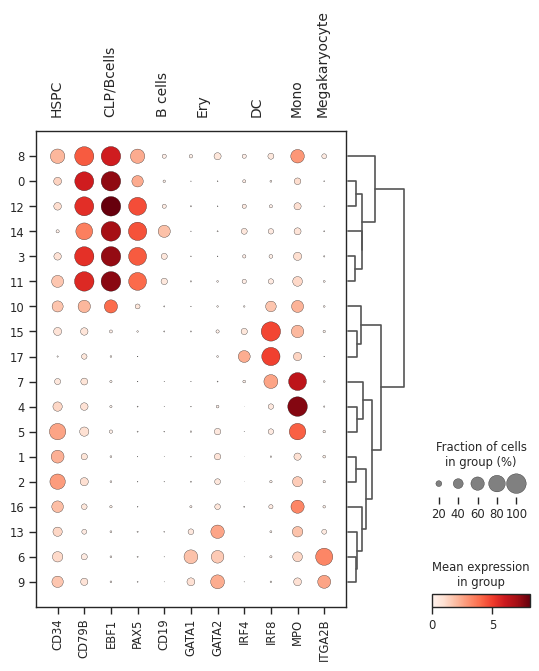

In [64]:
sc.pl.dotplot(ad, marker_dict, 'phenograph', dendrogram=True)

In [65]:
genes = pd.Series([
    "CD34", "CD38", # HSPC
    "CD79B", "EBF1", "PAX5", # CLP / B cell lineage 
    "CD19", "CD20", # Mature B cell markers
    "GATA1",  # Erythroid lineage
    "IRF8", # DC lineage
    "MPO", # Monocyte lineage
    "ITGA2B", #CD41 - Megakaryocyte,     
])
genes = genes[genes.isin(ad.var_names)]

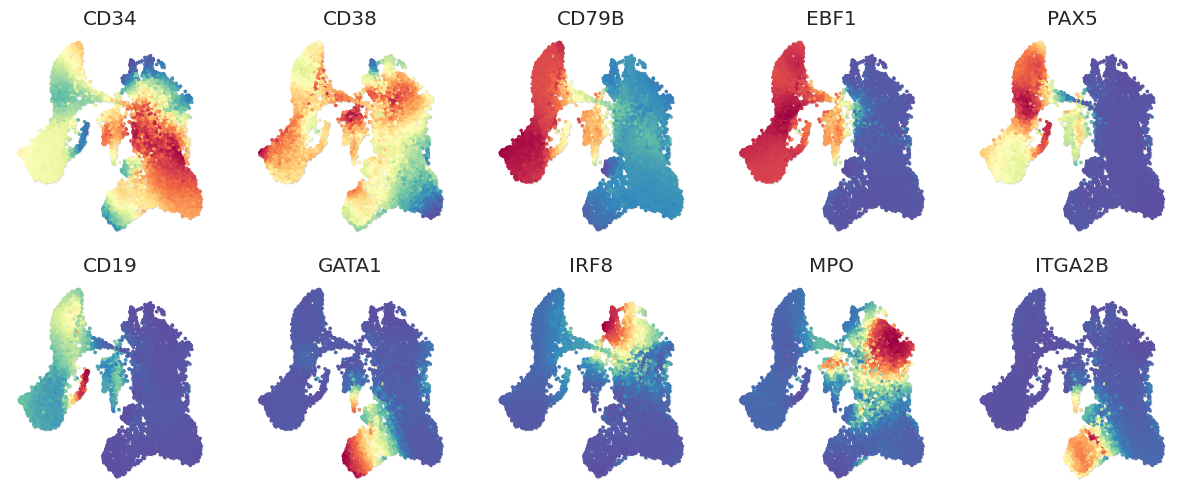

In [66]:
palantir.plot.plot_gene_expression(pd.DataFrame(ad.obsm['MAGIC_imputed_data'], 
                                                index=ad.obs_names, columns=ad.var_names),
                                   pd.DataFrame(ad.obsm['X_umap'], 
                                               index=ad.obs_names, columns=['x', 'y']), 
                                   genes)

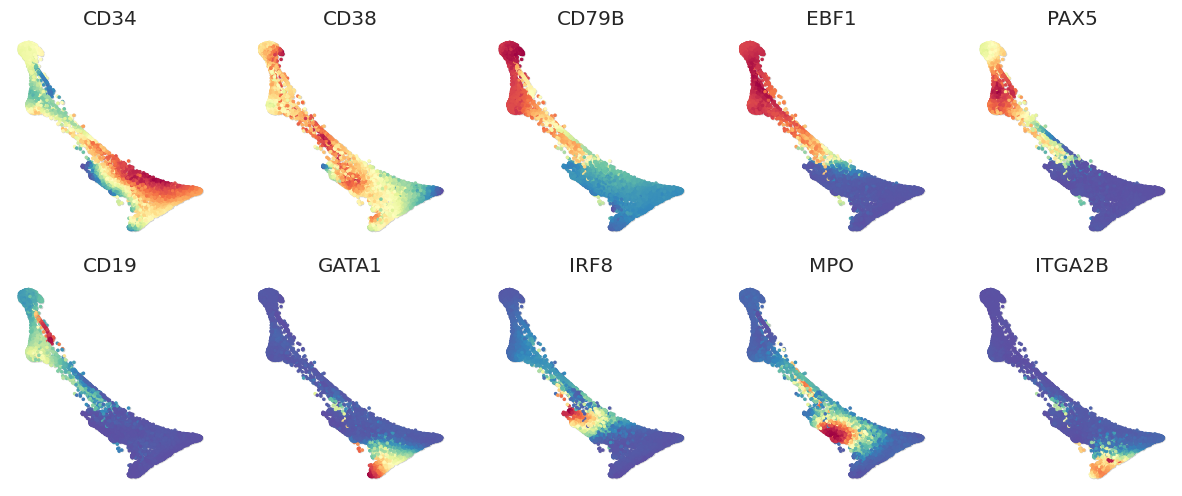

In [67]:
palantir.plot.plot_gene_expression(pd.DataFrame(ad.obsm['MAGIC_imputed_data'], 
                                                index=ad.obs_names, columns=ad.var_names),
                                   pd.DataFrame(ad.obsm['X_FDL'], 
                                               index=ad.obs_names, columns=['x', 'y']), 
                                   genes)

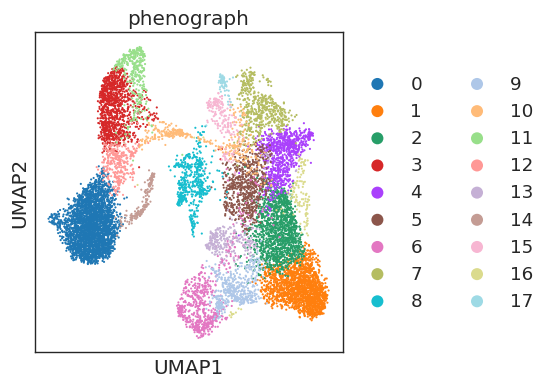

In [69]:
sc.pl.scatter(ad, basis='umap', color=['phenograph'])

In [100]:
cell_types = pd.Series("", index=ad.obs['phenograph'].values.categories)
cell_types['0'] = 'B cells'
cell_types['1'] = 'HSPC'
cell_types['2'] = 'HSPC'
cell_types['3'] = 'B cells'
cell_types['4'] = 'Mono'
cell_types['5'] = 'HSPC'
cell_types['6'] = 'Ery'
cell_types['7'] = 'DC'
cell_types['8'] = 'Doublets'
cell_types['9'] = 'MEP'
cell_types['10'] = 'CLP'
cell_types['11'] = 'B cells'
cell_types['12'] = 'B cells'
cell_types['13'] = 'Mast'
cell_types['14'] = 'B cells'
cell_types['15'] = 'DC'
cell_types['16'] = 'HSPC'
cell_types['17'] = 'DC'

In [101]:
ad.obs['celltype'] = cell_types[ad.obs['phenograph']].values

In [102]:
del ad.uns['celltype_colors']

... storing 'celltype' as categorical


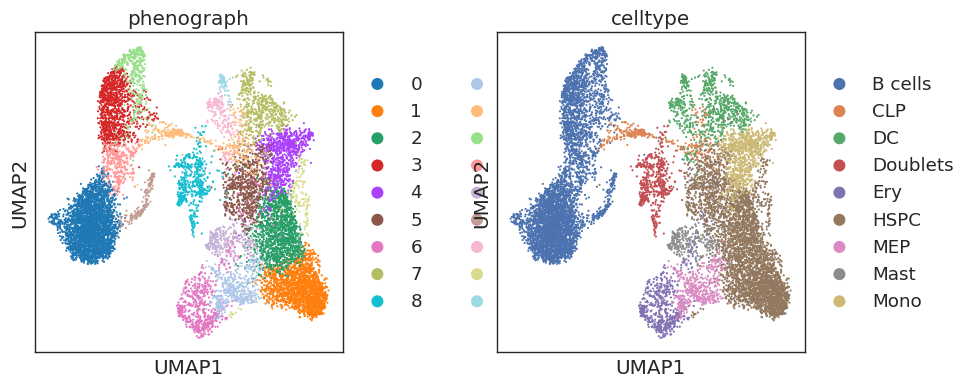

In [103]:
sc.pl.scatter(ad, basis='umap', color=['phenograph', 'celltype'])

# Save

In [104]:
# Attach raw counts
ad.raw = sc.AnnData(raw_ad[ad.obs_names, :][:, ad.var_names].X)

In [ ]:
ad.write(data_dir + 'cd34_multiome_rna.h5ad')

In [ ]:
# Export cell names for ATAC - only this subset of cells will be use for ATAC analysis
pd.DataFrame(ad.obs_names).to_csv(data_dir + 'cd34_multiome_cells.csv')